# Mini Project 1

**Author**: 
Doukouré Binta 
...

**Date**:

### Citation and Resources:
*Please include the citations for all tools, software, and publications referenced in the workflow. If you are basing your workflow on another previously published example notebook, please cite the name and DOI.*

#### Tools included in this workflow
*Cite the tools based on their preferred method (example through a Zenodo DOI or a publication)*

#### Workflows this work is based on (if applicable)
*If you started from another published workflow, please cite it here*

#### Publications
*Any publication that helped you build your example should be cited here*

#### Educational resources
*Any educational resource (for example Andy's Brain Book, FSL tutorials...) should be cited here.*

#### Dataset
Human Connectome project 

## Table of content
[1. Data Preparation](#1.-Data-Preparation)  
[2. Analysis](#2.-Analysis)  
[3. Results](#3.-Results) 


## Load software tools and import python libraries

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri


import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 16:51:19.031: Failed to load module "canberra-gtk-module"


In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

14:29:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:29:06: Debug: Adding duplicate animation handler for '1' type
14:29:06: Debug: Adding duplicate animation handler for '2' type
14:29:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:29:06: Debug: Adding duplicate animation handler for '1' type
14:29:06: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:22522): Gtk-CRITICAL **: 14:29:06.446: gtk_window_resize: assertion 'height > 0' failed


## 1. Data Preparation

### Dataload

In [4]:
subject_T1 = "drive-download-20251016T123238Z-1-001/T1w/T1w.nii.gz"

# Vizualize subject 
fsleyesDisplay.load(subject_T1)

In [15]:
print_dir_tree("drive-download-20251016T123238Z-1-001")

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii


In [2]:
subject_id = "101410"
bids_root = "drive-download-20251016T123238Z-1-001"
mkdir_no_exist(bids_root)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))

In [17]:
print_dir_tree(bids_root)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii


### Structural Preprocessing

#### Skull Stripping

In [6]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410")

Done with BET.


In [7]:
# Vizualize mask 
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'T1w', 'T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:21376): Gdk-WARNING **: 14:20:37.800: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [48]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w.nii.gz') # The brain without skull is in the derivatives folderRGe
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

#### Segmentation 

In [9]:
fast_target = betted_brain_path #

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [25]:
print_dir_tree(bids_root, max_depth=5)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- T1w.nii.gz
|--------------- T1w_fast_mixeltype.nii.gz
|--------------- T1w_fast_pve_0.nii.gz
|--------------- T1w_fast_pve_1.nii.gz
|--------------- T1w_fast_pve_2.nii.gz
|--------------- T1w_fast_pveseg.nii.gz
|--------------- T1w_fast_seg.nii.gz
|--------------- T1w_mask.nii.gz
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii


In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

### Funtional preprocessing 

In [11]:
#### Concatenate runs of interest
import nibabel as nib 
from nilearn.image import concat_imgs 

LR_run_path = op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii')
RL_run_path = op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')

LR_img = nib.load(LR_run_path)
RL_img = nib.load(RL_run_path)
print(LR_img.shape)

concatenated_run = concat_imgs([LR_img, RL_img])
print(concatenated_run.shape)

(91, 109, 91, 284)
(91, 109, 91, 568)


In [12]:
df_events_LR = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'events_LR.csv'))
df_events_RL = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'events_RL.csv'))


# Compute end time of first run (RL)
RL_end_time = df_events_RL['onset'].iloc[-1] + df_events_RL['duration'].iloc[-1]

# Shift the LR events
df_events_LR['onset'] = df_events_LR['onset'] + RL_end_time

# Concatenate
df_events = pd.concat([df_events_RL, df_events_LR], axis=0).reset_index(drop=True)
df_events.to_csv(op.join(preproc_root, 'sub-101410', 'func', 'events.csv'))

In [13]:
# Save the image
nib.save(concatenated_run, op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR.nii'))

In [9]:
print_dir_tree(bids_root)

|drive-download-20251016T123238Z-1-001/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- T1w.nii.gz
|--------------- T1w_fast_mixeltype.nii.gz
|--------------- T1w_fast_pve_0.nii.gz
|--------------- T1w_fast_pve_1.nii.gz
|--------------- T1w_fast_pve_2.nii.gz
|--------------- T1w_fast_pveseg.nii.gz
|--------------- T1w_fast_seg.nii.gz
|--------------- T1w_mask.nii.gz
|------------ func/
|--------------- events.csv
|--------------- tfMRI_MOTOR_moco.nii.par
|--------------- tfMRI_MOTOR_moco_smooth.nii.gz_smoothed-6mm.nii.gz
|--------------- tfMRI_MOTOR_moco.nii.mat/
|------------------ MAT_0000
|------------------ MAT_0001
|------------------ MAT_0002
|------------------ MAT_0003
|------------------ MAT_0004
|------------------ MAT_0005
|------------------ MAT_0006
|------------------ MAT_0007
|------------------ MAT_0008
|------------------ MAT_0009


#### Motion correction 

In [14]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR.nii')
path_moco_data = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco.nii

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [53]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.gz'))


(ipykernel_launcher.py:11156): Gdk-WARNING **: 14:17:39.303: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [ ]:
# MOCO parameters 

In [4]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000518,-0.005392,-0.002635,-0.331309,-0.163144,0.144720
1,0.000353,-0.005959,-0.002720,-0.326907,-0.156578,0.151960
2,0.000402,-0.005824,-0.002518,-0.338599,-0.153123,0.158276
3,0.000595,-0.005664,-0.002686,-0.333948,-0.160751,0.163877
4,0.000657,-0.005783,-0.002332,-0.334025,-0.156430,0.154814
...,...,...,...,...,...,...
563,0.000354,0.000874,-0.000402,0.062152,-0.036825,0.061909
564,0.000470,0.000874,-0.000450,0.062149,-0.034727,0.056730
565,0.000552,0.000874,-0.000534,0.057100,-0.048716,0.056725
566,0.000370,0.000874,-0.000481,0.062145,-0.044326,0.056731


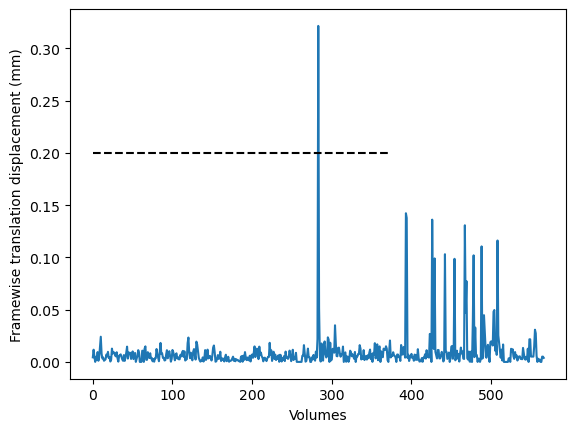

In [11]:
import matplotlib.pyplot as plt 

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

In [16]:
# Gaussian Smoothing 
input_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.gz')
output_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco_smooth.nii.gz')
cmd = 'fslmaths {} -s {} {}'.format(input_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',input_path, '-s', str(6/2.3548), '{}'.format(output_path)])

CompletedProcess(args=['fslmaths', 'drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco.nii.gz', '-s', '2.547987090198743', 'drive-download-20251016T123238Z-1-001/derivatives/preprocessed_data/sub-101410/func/tfMRI_MOTOR_moco_smooth.nii.gz'], returncode=0)

In [14]:
fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(output_path)

## GLM part 

In [5]:
import os.path as op
import pandas as pd
import nibabel as nib
from nilearn.image import concat_imgs
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

df_events_RL = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'events_RL.csv'))
df_events_LR = pd.read_csv(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'events_LR.csv'))

# Compute end time of first run (RL)
RL_end_time = df_events_RL['onset'].iloc[-1] + df_events_RL['duration'].iloc[-1]

# Shift the LR events
df_events_LR['onset'] = df_events_LR['onset'] + RL_end_time

# Concatenate
df_events = pd.concat([df_events_RL, df_events_LR], axis=0).reset_index(drop=True)

# Ensure correct column naming for Nilearn
if 'condition' in df_events.columns and 'trial_type' not in df_events.columns:
    df_events.rename(columns={'condition': 'trial_type'}, inplace=True)

# Save cleanly
output_path = op.join(preproc_root, 'sub-101410', 'func', 'events.csv')
df_events.to_csv(output_path, index=False)

output_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco_smooth.nii.gz')
fmri_img = nib.load(output_path)

events_path = op.join(preproc_root, 'sub-101410', 'func', 'events.csv')
events = pd.read_csv(events_path)

fmri_glm = FirstLevelModel(
    t_r=0.72,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=None,
    high_pass=.01
)

fmri_glm = fmri_glm.fit(fmri_img, events)


design_matrix = fmri_glm.design_matrices_[0]

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


## Plotting and saving design matrix

Regressor names: ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't', 'constant']


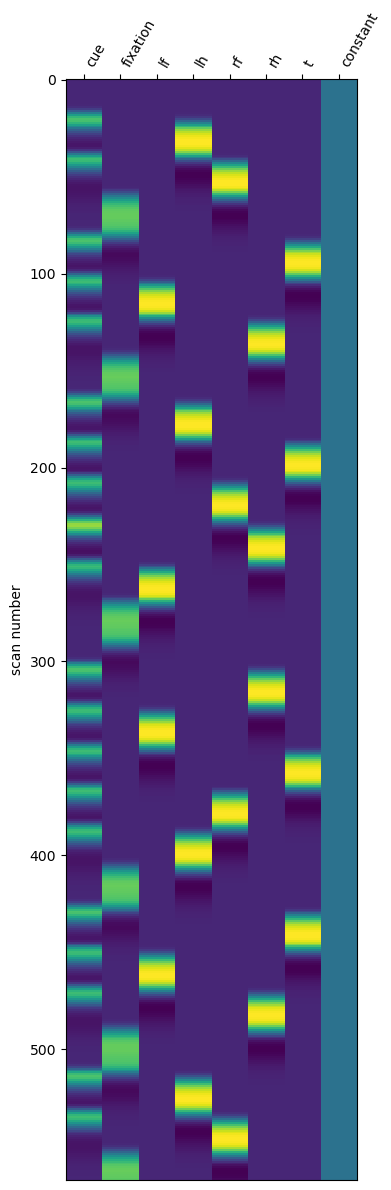

In [6]:

fig, ax = plt.subplots(figsize=(4, 12))
plot_design_matrix(design_matrix, ax=ax)
# Save the plot
save_path = op.join(preproc_root, 'sub-101410', 'func', 'design_matrix_plot.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
# Get regressor names from the design matrix
regressor_names = fmri_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)

## Adding drift regressors

Total time frames: 568


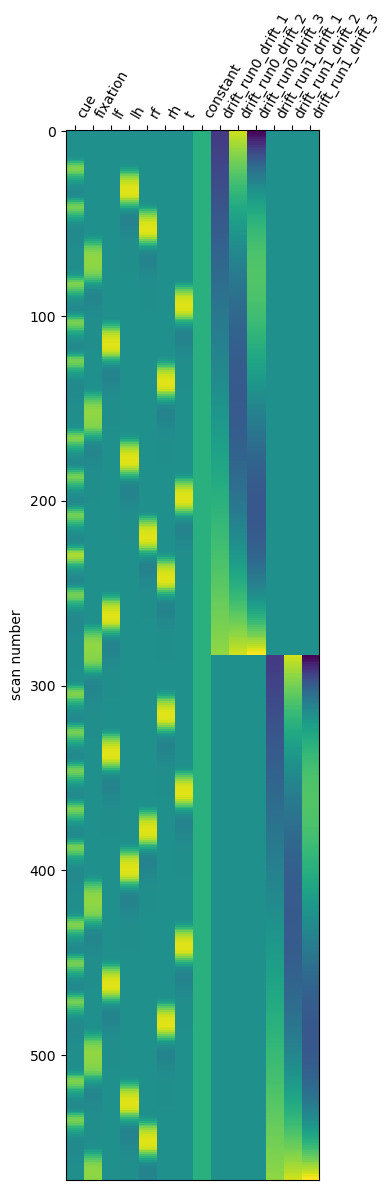

In [7]:
from nilearn.glm.first_level.design_matrix import _make_drift
from nilearn.plotting import plot_design_matrix
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

#Parameters
TR = fmri_img.header.get_zooms()[3]
nbr_time_frame = fmri_img.shape[3]
print("Total time frames:", nbr_time_frame)


n_runs = 2
scans_per_run = [nbr_time_frame // n_runs] * n_runs 
taskRT = TR

design_mat = fmri_glm.design_matrices_[0].copy()
design_matrix_drifts = design_mat.copy()

for run in range(n_runs):
    n_scans = scans_per_run[run]
    start_idx = run * n_scans
    end_idx = (run + 1) * n_scans

    frame_times = np.arange(n_scans) * taskRT
    run_drift, drift_names = _make_drift(
        drift_model='polynomial',
        frame_times=frame_times,
        order=3,
        high_pass=0.01
    )
    for col_idx, name in enumerate(drift_names):
        if "constant" in name.lower():
            continue 

        col = np.zeros(len(design_matrix_drifts))
        col[start_idx:end_idx] = run_drift[:, col_idx]
        design_matrix_drifts[f'drift_run{run}_{name}'] = col

# Plot and save 
fig, ax = plt.subplots(figsize=(4, 12))
plot_design_matrix(design_matrix_drifts, ax=ax)
save_path = op.join(preproc_root, 'sub-101410', 'func', 'design_matrix_drifts_per_run.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

## Adding motion regressors

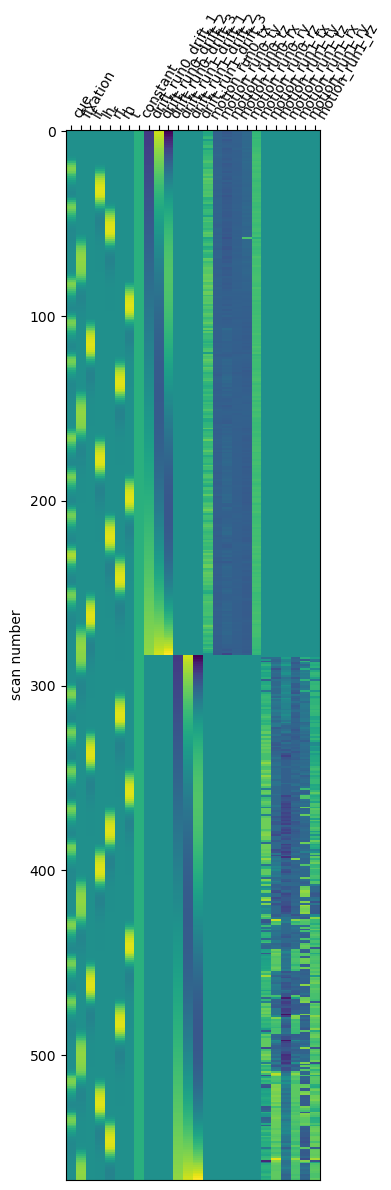

In [8]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

# --- Load motion parameters ---
motion_params_path = op.join(preproc_root, 'sub-101410', 'func', 'tfMRI_MOTOR_moco.nii.par')
motion_params = load_mot_params_fsl_6_dof(motion_params_path)

# Check that motion parameters match total frames
if motion_params.shape[0] != nbr_time_frame:
    raise ValueError(f"Number of motion parameters ({motion_params.shape[0]}) "
                     f"does not match number of time points ({nbr_time_frame})")

# Define basic parameters
n_runs = 2
scans_per_run = [nbr_time_frame // n_runs] * n_runs  # adjust if needed
motion_regressor_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

# Copy the design matrix that already has your drifts
design_matrix = design_matrix_drifts.copy()

# --- Add run-specific motion regressors ---
for run in range(n_runs):
    n_scans = scans_per_run[run]
    start_idx = run * n_scans
    end_idx = (run + 1) * n_scans

    # Extract motion parameters for this run
    run_motion = motion_params.iloc[start_idx:end_idx].to_numpy()

    if run_motion.shape[0] != n_scans:
        raise ValueError(f"Run {run}: Expected {n_scans} scans but got {run_motion.shape[0]}")

    for i, name in enumerate(motion_regressor_names):
        # Zero vector for all time points
        col = np.zeros(nbr_time_frame)
        # Fill only the relevant run
        col[start_idx:end_idx] = run_motion[:, i]
        # Add to design matrix with run-specific name
        design_matrix[f'motion_run{run}_{name}'] = col

# --- Plot and save ---
fig, ax = plt.subplots(figsize=(4, 12))
plot_design_matrix(design_matrix, ax=ax)
save_path = op.join(preproc_root, 'sub-101410', 'func', 'design_matrix_drifts_motions_per_run.png')
fig.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

## Fitting the data

In [9]:
fit_glm = FirstLevelModel(t_r=0.72,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='none',
                           high_pass=0.01)


fit_glm.fit(fmri_img, design_matrices=[design_matrix])

FirstLevelModel(drift_model='none', hrf_model='spm', t_r=0.72)

## Statistical Maps

BETA MAP FOR cue


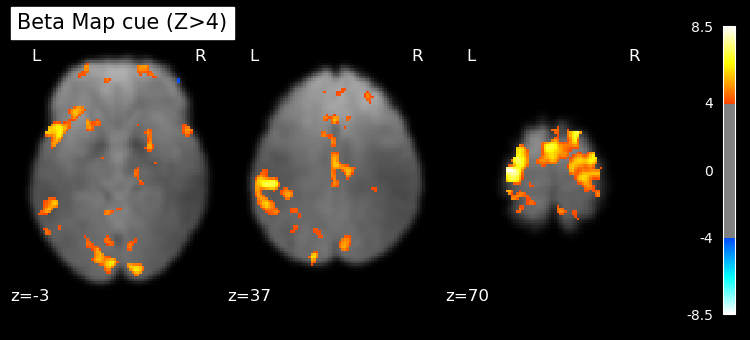

BETA MAP FOR fixation


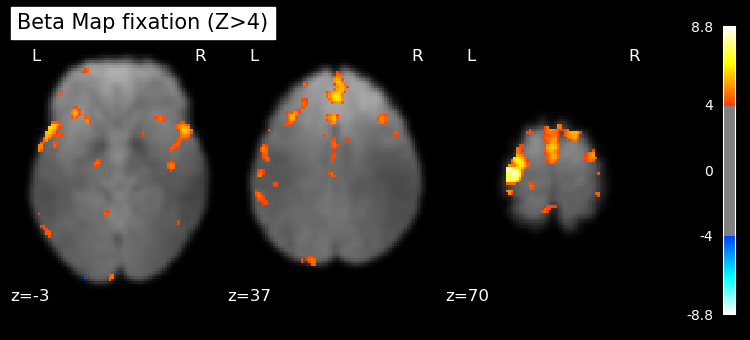

BETA MAP FOR lf


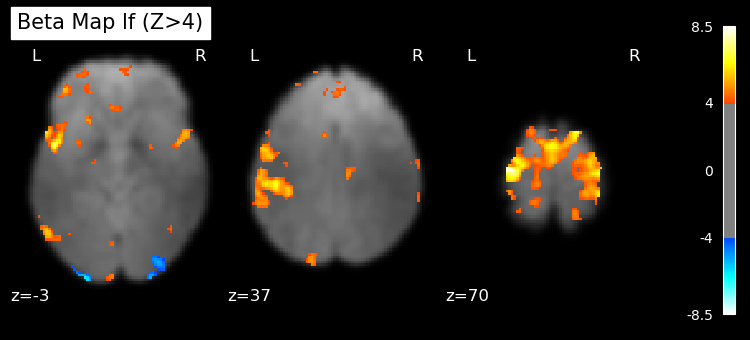

BETA MAP FOR lh


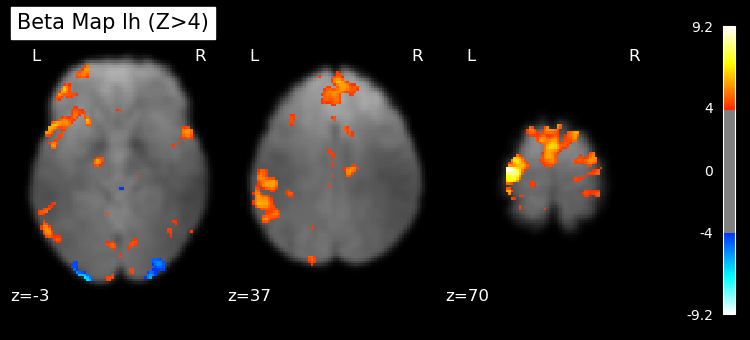

BETA MAP FOR rf


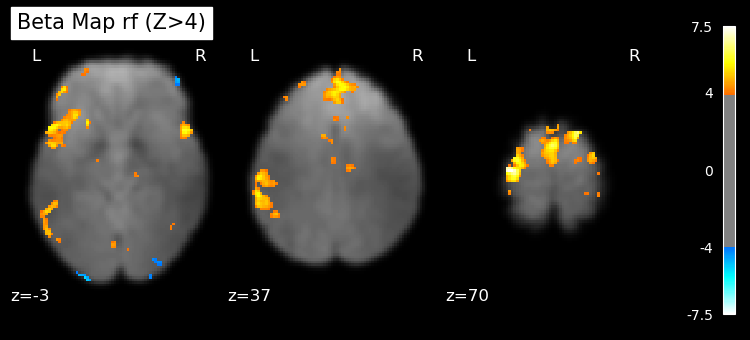

BETA MAP FOR rh


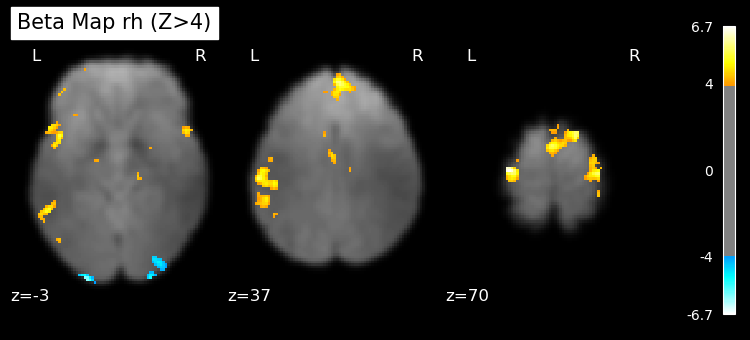

BETA MAP FOR t


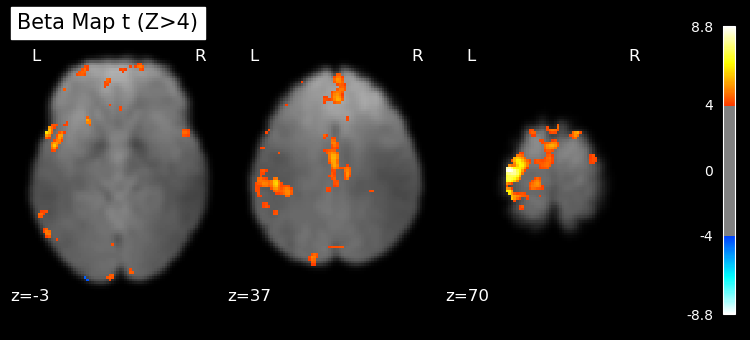

In [30]:
fit_glm = FirstLevelModel(t_r=0.72, drift_model='None',noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    high_pass=.01)
fit_glm.fit(fmri_img, design_matrices=[design_matrix])

conditions = {
    'cue': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
    'fixation': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'lf': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'lh': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'rf': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'rh': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    't': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    
}
from nilearn.plotting import plot_contrast_matrix
import nibabel as nib
from nilearn.glm import threshold_stats_img
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map
cluster_size = 10 
fdr_rate = 0.05 

for condition in conditions :
    regressor=conditions[condition]
    print(f'BETA MAP FOR {condition}') 
    beta_map = fit_glm.compute_contrast(regressor, output_type='z_score')
    nib.save(beta_map, f'beta_map_{condition}.nii.gz')
    mean_img_ = mean_img(fmri_img),
    # clean_map, threshold = threshold_stats_img(beta_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
    threshold = 4
    plot_stat_map(beta_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title=f'Beta Map {condition} (Z>{threshold})')
    plt.show()

## Hand motion against feet motion

/opt/conda/lib/python3.11/site-packages/nilearn/glm/contrasts.py:108: UserWarning: t contrasts should be of length P=26, but it has length 8. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


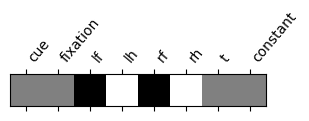

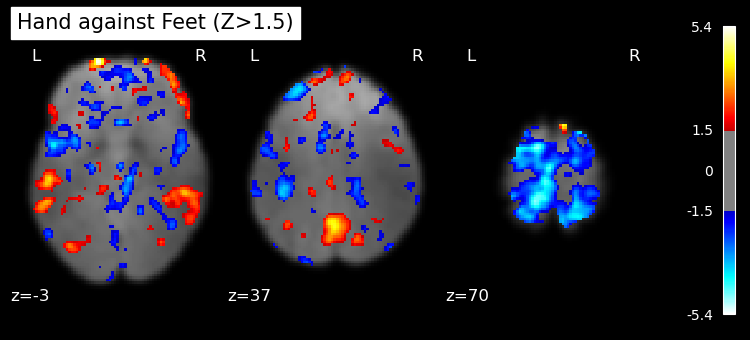

In [29]:
# Ensure the contrast vector has the correct number of elements (matching the design matrix)
n_conditions = n_conditions = fmri_glm.design_matrices_[0].shape[1]
hand_against_feet = np.zeros(n_conditions)

# Fill in the relevant contrast values for "lh" vs "rh" and "lf" vs "rf"
hand_against_feet[3] = 1  # 'lh' condition
hand_against_feet[5] = 1  # 'rh' condition
hand_against_feet[2] = -1  # 'lf' condition
hand_against_feet[4] = -1  # 'rf' condition


# Plot the contrast matrix
plot_contrast_matrix(hand_against_feet, design_matrix=fmri_glm.design_matrices_[0])

# Compute the contrast and save the z-map
z_map = fit_glm.compute_contrast(hand_against_feet, output_type='z_score')
nib.save(z_map, 'z_map_handsvsfeet.nii.gz')

# clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
mean_img_ = mean_img(fmri_img)
threshold=1.5
plot_stat_map(z_map, bg_img=mean_img_, threshold=1.5,
              display_mode='z', cut_coords=[-3, 37, 70], black_bg=True,
              title=f'Hand against Feet (Z>{threshold})')

# Show the plot
plt.show()

## AAL atlas

{1: 'Precentral_L', 2: 'Precentral_R', 3: 'Frontal_Sup_L', 4: 'Frontal_Sup_R', 5: 'Frontal_Sup_Orb_L', 6: 'Frontal_Sup_Orb_R', 7: 'Frontal_Mid_L', 8: 'Frontal_Mid_R', 9: 'Frontal_Mid_Orb_L', 10: 'Frontal_Mid_Orb_R', 11: 'Frontal_Inf_Oper_L', 12: 'Frontal_Inf_Oper_R', 13: 'Frontal_Inf_Tri_L', 14: 'Frontal_Inf_Tri_R', 15: 'Frontal_Inf_Orb_L', 16: 'Frontal_Inf_Orb_R', 17: 'Rolandic_Oper_L', 18: 'Rolandic_Oper_R', 19: 'Supp_Motor_Area_L', 20: 'Supp_Motor_Area_R', 21: 'Olfactory_L', 22: 'Olfactory_R', 23: 'Frontal_Sup_Medial_L', 24: 'Frontal_Sup_Medial_R', 25: 'Frontal_Med_Orb_L', 26: 'Frontal_Med_Orb_R', 27: 'Rectus_L', 28: 'Rectus_R', 29: 'Insula_L', 30: 'Insula_R', 31: 'Cingulum_Ant_L', 32: 'Cingulum_Ant_R', 33: 'Cingulum_Mid_L', 34: 'Cingulum_Mid_R', 35: 'Cingulum_Post_L', 36: 'Cingulum_Post_R', 37: 'Hippocampus_L', 38: 'Hippocampus_R', 39: 'ParaHippocampal_L', 40: 'ParaHippocampal_R', 41: 'Amygdala_L', 42: 'Amygdala_R', 43: 'Calcarine_L', 44: 'Calcarine_R', 45: 'Cuneus_L', 46: 'Cuneus_

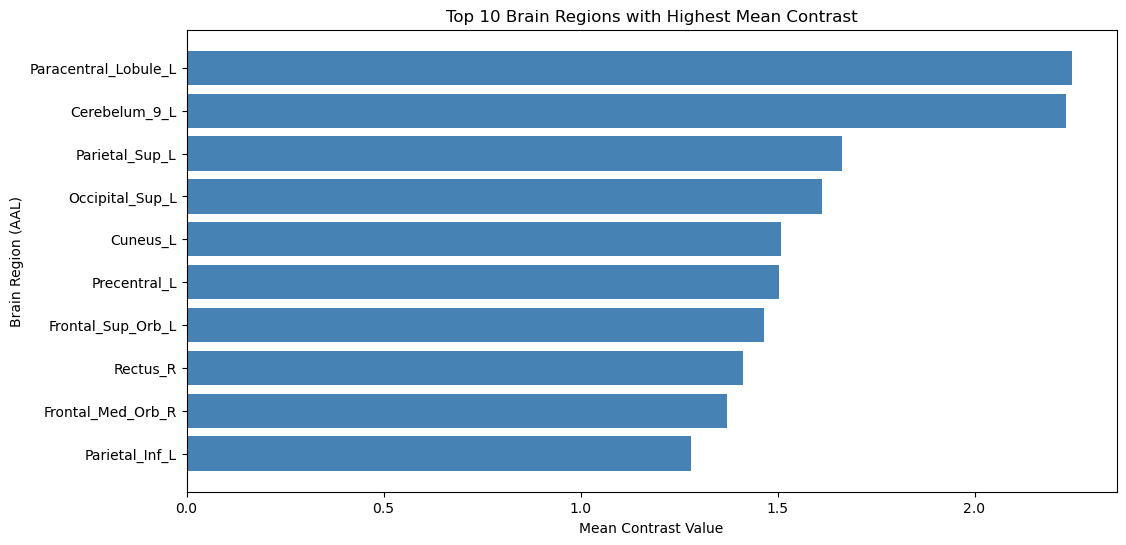

['Paracentral_Lobule_L' 'Cerebelum_9_L' 'Parietal_Sup_L' 'Occipital_Sup_L'
 'Cuneus_L' 'Precentral_L' 'Frontal_Sup_Orb_L' 'Rectus_R'
 'Frontal_Med_Orb_R' 'Parietal_Inf_L']
[2.24802113 2.23163671 1.66239224 1.61192709 1.50923422 1.50348579
 1.46678419 1.4133123  1.37107493 1.2801289 ]


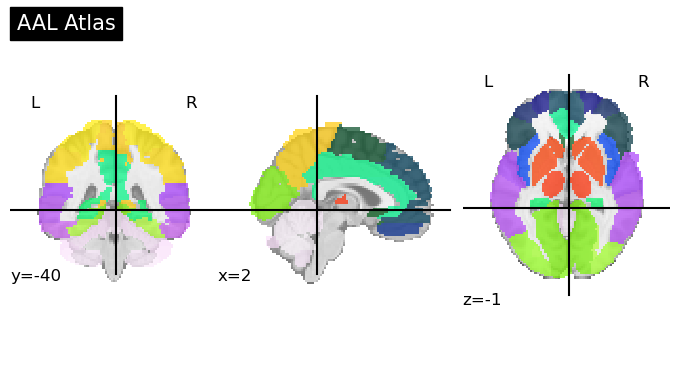

Region: Precentral_L, ID: 2001.0
Region: Precentral_R, ID: 2002.0
Region: Frontal_Sup_L, ID: 2101.0
Region: Frontal_Sup_R, ID: 2102.0
Region: Frontal_Sup_Orb_L, ID: 2111.0
Region: Frontal_Sup_Orb_R, ID: 2112.0
Region: Frontal_Mid_L, ID: 2201.0
Region: Frontal_Mid_R, ID: 2202.0
Region: Frontal_Mid_Orb_L, ID: 2211.0
Region: Frontal_Mid_Orb_R, ID: 2212.0
Region: Frontal_Inf_Oper_L, ID: 2301.0
Region: Frontal_Inf_Oper_R, ID: 2302.0
Region: Frontal_Inf_Tri_L, ID: 2311.0
Region: Frontal_Inf_Tri_R, ID: 2312.0
Region: Frontal_Inf_Orb_L, ID: 2321.0
Region: Frontal_Inf_Orb_R, ID: 2322.0
Region: Rolandic_Oper_L, ID: 2331.0
Region: Rolandic_Oper_R, ID: 2332.0
Region: Supp_Motor_Area_L, ID: 2401.0
Region: Supp_Motor_Area_R, ID: 2402.0
Region: Olfactory_L, ID: 2501.0
Region: Olfactory_R, ID: 2502.0
Region: Frontal_Sup_Medial_L, ID: 2601.0
Region: Frontal_Sup_Medial_R, ID: 2602.0
Region: Frontal_Med_Orb_L, ID: 2611.0
Region: Frontal_Med_Orb_R, ID: 2612.0
Region: Rectus_L, ID: 2701.0
Region: Rectus_R,

In [29]:
# Load AAL atlas and extract indices and labels
from nilearn import datasets,plotting
from nilearn.datasets import fetch_development_fmri, fetch_atlas_aal
from nilearn.input_data import NiftiLabelsMasker
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = aal_atlas.maps
atlas_indices = range(1, len(aal_atlas.labels) + 1)  # Create indices starting from 1
atlas_labels = aal_atlas.labels

# Create dictionary mapping indices to labels
labels_dict = dict(zip(atlas_indices, atlas_labels))

# Example output
print(labels_dict)

labels_dict = dict(zip(atlas_indices, atlas_labels))

#Get the MNI coordinates of the maximum z-score
z_data = z_map.get_fdata()
max_z = np.nanmax(z_data)
max_coords_voxel = np.unravel_index(np.nanargmax(z_data), z_data.shape)
max_coords_mni = nib.affines.apply_affine(z_map.affine, max_coords_voxel)

print(f"Maximum z-score: {max_z}")
print(f"Voxel coordinates: {max_coords_voxel}")
print(f"MNI coordinates: {max_coords_mni}")

#Load your contrast map
contrast_img = nib.load('z_map_handsvsfeet.nii.gz')

# Apply masking to extract the maximal activation region
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
time_series = masker.fit_transform(contrast_img)
mean_contrast_values = np.mean(time_series, axis=0)

# Identify the index of the region with the maximum contrast
max_region_index = np.argmax(mean_contrast_values)
max_region_name = atlas_labels[max_region_index]  # Retrieve the corresponding region name

# Output the results
if max_region_name == "Unknown":
    print("Region with maximal contrast is labeled as 'Unknown'. Please verify atlas alignment.")
else:
    print(f"The region with maximal contrast is: {max_region_name}")
#Identify top regions
sorted_indices = np.argsort(mean_contrast_values)[::-1]
sorted_contrast_values = mean_contrast_values[sorted_indices]
sorted_labels = np.array(atlas_labels)[sorted_indices]

# Plot bar chart for the top 10 regions
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels[:10], sorted_contrast_values[:10], color='steelblue')
plt.xlabel("Mean Contrast Value")
plt.ylabel("Brain Region (AAL)")
plt.title("Top 10 Brain Regions with Highest Mean Contrast")
plt.gca().invert_yaxis()
plt.show()
print(sorted_labels[:10])
print( sorted_contrast_values[:10])

# Plot the atlas
plotting.plot_roi(atlas_img, title='AAL Atlas', display_mode='ortho')
plt.show()
# Load the atlas data
atlas_img = nib.load(aal_atlas.maps)
atlas_data = atlas_img.get_fdata()
# Print out all labels along with the unique IDs for clarity
unique_ids = np.unique(atlas_data)
for label, unique_id in zip(atlas_labels, unique_ids[1:]):  # Skip 0 (background)
    print(f"Region: {label}, ID: {unique_id}")

## Top 10 regions

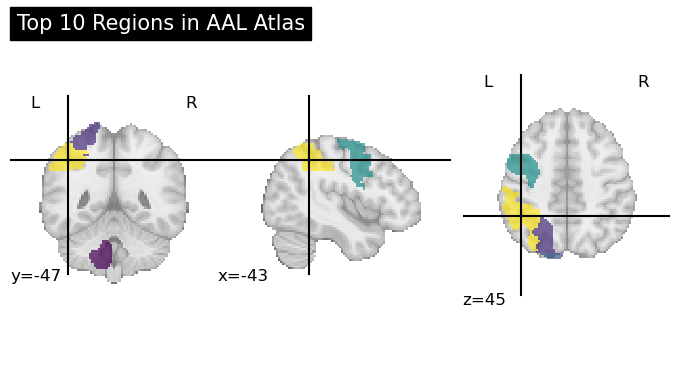

In [33]:
top_10_region_ids = region_ids = [6401, 9071, 6101, 5101, 5011, 2001, 2111, 2702, 2612, 6201]

highlighted_data = np.zeros_like(atlas_data)

for i, region_id in enumerate(top_10_region_ids, start=1):
    highlighted_data[atlas_data == region_id] = i

highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# Plot the highlighted regions with a color map
plotting.plot_roi(
    highlighted_img,
    title="Top 10 Regions in AAL Atlas",
    display_mode='ortho',
    cmap='viridis',  
    colorbar=False
)
plt.show()

## Observing top 10 brain regions intesities

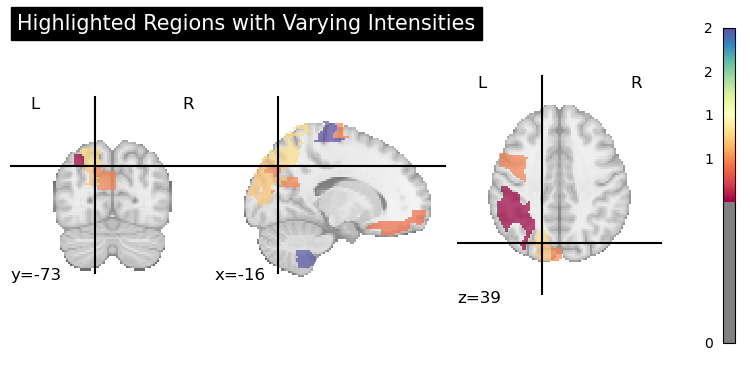

In [32]:
# Define the region IDs and their corresponding intensities
from nilearn import image
region_ids = [6401, 9071, 6101, 5101, 5011, 2001, 2111, 2702, 2612, 6201]
intensities = [2.24802113, 2.23163671, 1.66239224, 1.61192709, 1.50923422, 
               1.50348579, 1.46678419, 1.4133123, 1.37107493, 1.2801289]  # Define intensities for each region

# Create a mask for the highlighted regions with different intensities
highlighted_data = np.zeros_like(atlas_data)

# Assign each region the specified intensity
for region_id, intensity in zip(region_ids, intensities):
    highlighted_data[atlas_data == region_id] = intensity

# Create a new Nifti image for the highlighted regions
highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# Plot the highlighted regions with a color map
plotting.plot_roi(
    highlighted_img,
    title="Highlighted Regions with Varying Intensities",
    display_mode='ortho',
    cmap='Spectral',  # Color map to differentiate regions
    colorbar=True
)
plt.show()
# # Define the region IDs and their corresponding intensities
# region_ids = [6401, 9071, 6101, 5101, 5011, 2001, 2111, 2702, 2612, 6201]
# intensities = [2.24802113, 2.23163671, 1.66239224, 1.61192709, 1.50923422, 
#                1.50348579, 1.46678419, 1.4133123, 1.37107493, 1.2801289]  # Define intensities for each region

# # Create a mask for the highlighted regions with different intensities
# highlighted_data = np.zeros_like(atlas_data)

# # Assign each region the specified intensity
# for region_id, intensity in zip(region_ids, intensities):
#     highlighted_data[atlas_data == region_id] = intensity

# # Create a new Nifti image for the highlighted regions
# highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# # Set the color map range for improved contrast
# vmin = min(intensities)
# vmax = max(intensities)

# # Plot the highlighted regions with an appealing color map
# plotting.plot_roi(
#     highlighted_img,
#     bg_img=datasets.load_mni152_template(),  # Adds anatomical context
#     title="Highlighted Regions with Varying Intensities",
#     display_mode='ortho',
#     cmap='inferno',  # High-contrast, visually appealing color map
#     colorbar=True,
#     alpha=0.9,  # Transparency for non-highlighted areas
#     vmin=vmin,  # Set color map minimum for clear scaling
#     vmax=vmax   # Set color map maximum for clear scaling
# )
# plt.show()